# **Prediksi Polusi Udara**

### **Import Library**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM

### **Load Dataset**

In [3]:
df = pd.read_csv('final.csv')

df.head()

,created_at,entry_id,field1,field2,latitude,longitude,elevation,status
0,2024-12-11T12:41:13+00:00,1,402.81,0.64,NaN,NaN,NaN,NaN
1,2024-12-11T12:41:29+00:00,2,402.69,0.65,NaN,NaN,NaN,NaN
2,2024-12-11T12:41:45+00:00,3,402.76,0.64,NaN,NaN,NaN,NaN
3,2024-12-11T12:42:01+00:00,4,402.66,0.65,NaN,NaN,NaN,NaN
4,2024-12-11T12:42:17+00:00,5,402.66,0.65,NaN,NaN,NaN,NaN


In [4]:
df.drop(columns=['latitude', 'longitude', 'elevation', 'status'], inplace=True)

df.head()

,created_at,entry_id,field1,field2
0,2024-12-11T12:41:13+00:00,1,402.81,0.64
1,2024-12-11T12:41:29+00:00,2,402.69,0.65
2,2024-12-11T12:41:45+00:00,3,402.76,0.64
3,2024-12-11T12:42:01+00:00,4,402.66,0.65
4,2024-12-11T12:42:17+00:00,5,402.66,0.65


In [5]:
df.rename(columns={'field1': 'CO2', 'field2': 'CO'}, inplace=True)

df.tail(3)

,created_at,entry_id,CO2,CO
160782,2025-01-12T01:09:41+00:00,160783,424.71,0.80
160783,2025-01-12T01:09:57+00:00,160784,425.55,0.80
160784,2025-01-12T01:10:13+00:00,160785,431.22,0.81


In [6]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160785 entries, 0 to 160784
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype              
---  ------      --------------   -----              
 0   created_at  160785 non-null  datetime64[ns, UTC]
 1   entry_id    160785 non-null  int64              
 2   CO2         160785 non-null  float64            
 3   CO          160785 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(2), int64(1)
memory usage: 4.9 MB


### **Exploratory Data Analysis**

**Resampling data menjadi permenit**

In [8]:
# Set kolom 'created_at' sebagai index
df = df.set_index('created_at')

In [9]:
df_rounded = df.round(2)

In [10]:
# Resample per menit, ambil mean (rata-rata) untuk setiap menit
df_per_2menit = df_rounded.resample('2min').mean()
df_per_2menit = df_per_2menit.round(2)
df_per_2menit

,entry_id,CO2,CO
created_at,,,
2024-12-11 12:40:00+00:00,2.0,402.75,0.64
2024-12-11 12:42:00+00:00,7.5,402.70,0.65
2024-12-11 12:44:00+00:00,14.5,402.73,0.66
2024-12-11 12:46:00+00:00,NaN,NaN,NaN
2024-12-11 12:48:00+00:00,NaN,NaN,NaN
...,...,...,...
2025-01-12 01:02:00+00:00,160758.5,430.33,0.80
2025-01-12 01:04:00+00:00,160765.5,428.32,0.80
2025-01-12 01:06:00+00:00,160773.0,430.19,0.80


<Axes: xlabel='created_at'>

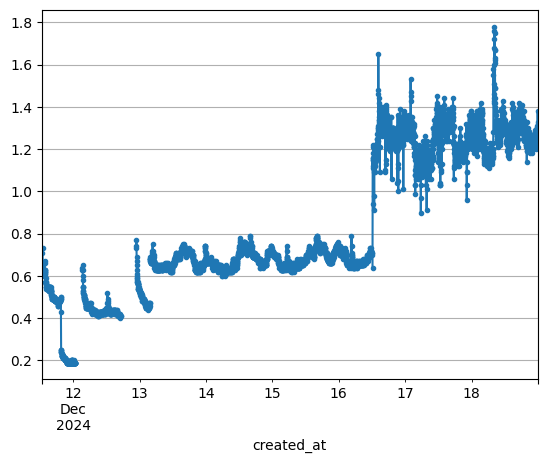

In [11]:
df_per_2menit['CO']['2024-12-11':'2024-12-18'].plot(grid=True, marker='.')

<Axes: xlabel='created_at'>

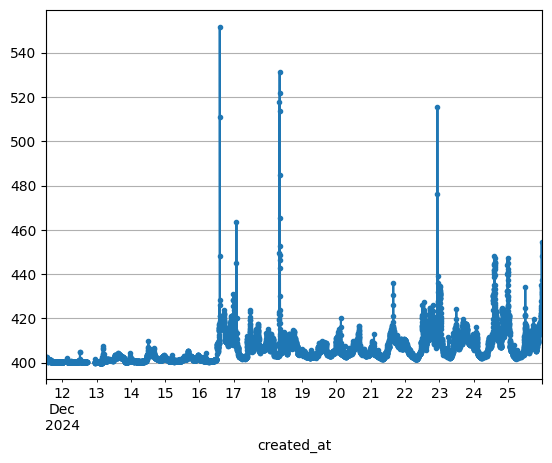

In [12]:
df_per_2menit['CO2']['2024-12-11':'2024-12-25'].plot(grid=True, marker='.')

<Axes: xlabel='created_at'>

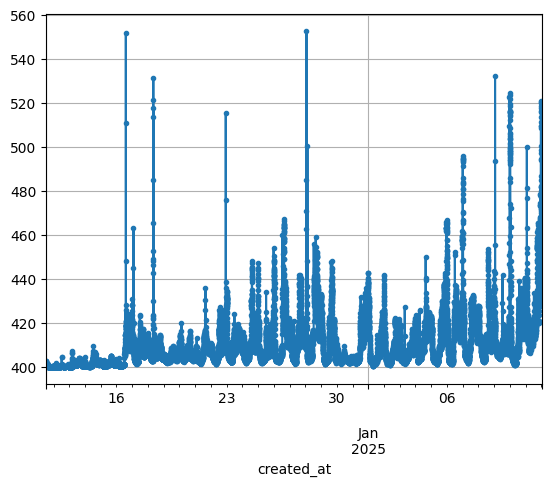

In [13]:
df_per_2menit['CO2']['2024-12-11':'2025-01-12'].plot(grid=True, marker='.')

<Axes: xlabel='created_at'>

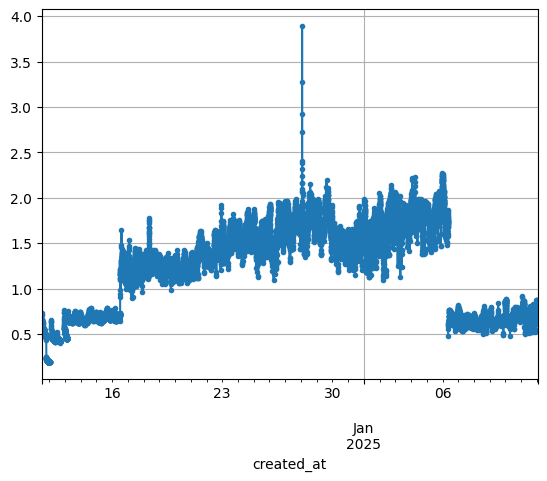

In [14]:
df_per_2menit['CO']['2024-12-11':'2025-01-12'].plot(grid=True, marker='.')

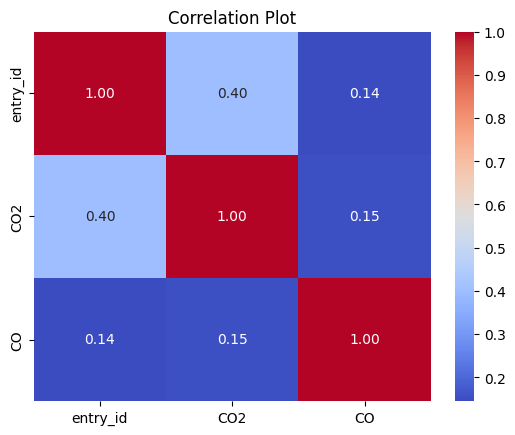

In [15]:
correlation = df_per_2menit[['entry_id','CO2', 'CO']].corr()

sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Plot')
plt.show()

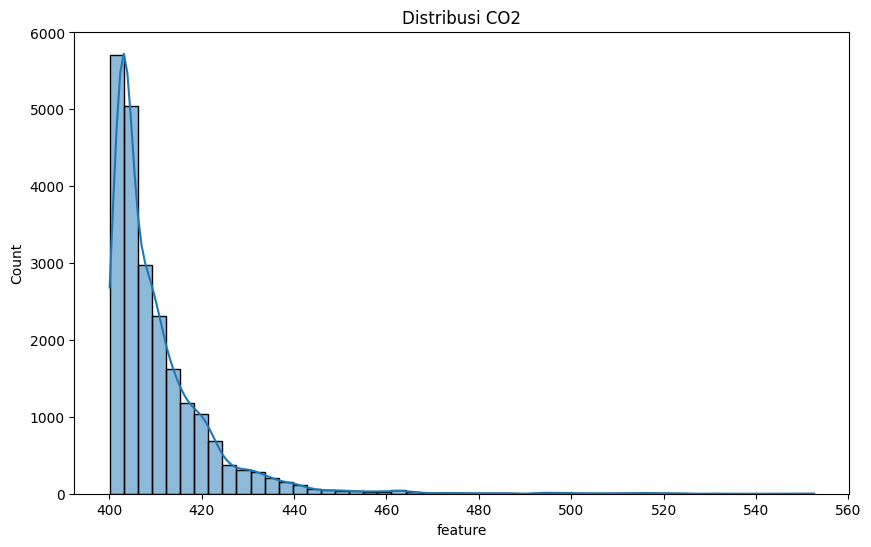

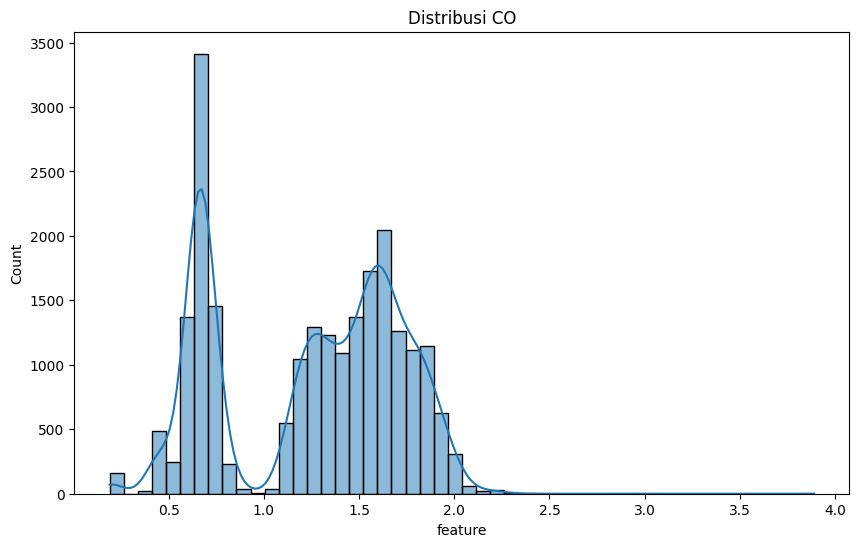

In [16]:
numeric_feature = ["CO2", "CO"]

for feature in numeric_feature:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_per_2menit[feature], kde=True, bins=50)
    plt.title(f"Distribusi {feature}")
    plt.xlabel("feature")

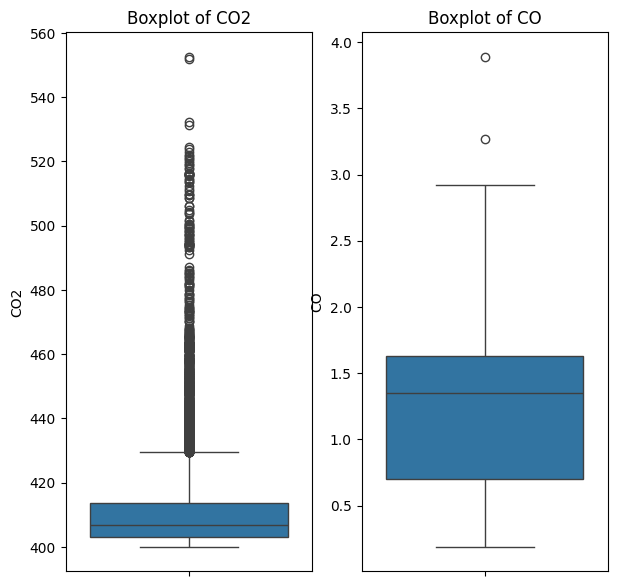

In [17]:
plt.figure(figsize=(7, 7))

plt.subplot2grid((2, 2), (0, 0), rowspan=2, colspan=1)
sns.boxplot( df_per_2menit['CO2'], label='CO2')
plt.title("Boxplot of CO2")


plt.subplot2grid((2, 2), (0, 1), rowspan=2, colspan=1)
sns.boxplot(df_per_2menit['CO'], label='CO')
plt.title("Boxplot of CO")
plt.show()

In [18]:
df_per_2menit.duplicated().sum()

293

In [19]:
df_per_2menit = df_per_2menit.interpolate(method='time')

In [20]:
df_per_2menit.isnull().sum()

entry_id    0
CO2         0
CO          0
dtype: int64

In [21]:
# Hapus baris duplikat (hanya jika semua kolom sama persis)
df_per_2menit = df_per_2menit.drop_duplicates()

In [22]:
df_per_2menit.duplicated().sum()

0

**Pemodelan**

In [23]:
scaler = MinMaxScaler()

In [24]:
df_scaled = df_per_2menit[['CO2', 'CO']]
df_scaled.head(1)

,CO2,CO
created_at,,
2024-12-11 12:40:00+00:00,402.75,0.64


In [25]:
scaled_df = scaler.fit_transform(df_scaled)
scaled_df = pd.DataFrame(scaled_df, index=df_scaled.index, columns=df_scaled.columns)
scaled_df

,CO2,CO
created_at,,
2024-12-11 12:40:00+00:00,0.017571,0.121622
2024-12-11 12:42:00+00:00,0.017244,0.124324
2024-12-11 12:44:00+00:00,0.017440,0.127027
2024-12-11 12:46:00+00:00,0.016772,0.129730
2024-12-11 12:48:00+00:00,0.016103,0.132432
...,...,...
2025-01-12 01:02:00+00:00,0.198400,0.164865
2025-01-12 01:04:00+00:00,0.185222,0.164865
2025-01-12 01:06:00+00:00,0.197482,0.164865


In [26]:
N_FEATURES = len(scaled_df.columns)
N_FEATURES

2

In [27]:
data = scaled_df.values
data

array([[0.01757147, 0.12162162],
       [0.01724364, 0.12432432],
       [0.01744034, 0.12702703],
       ...,
       [0.1974823 , 0.16486486],
       [0.19459743, 0.16486486],
       [0.20423551, 0.16756757]])

In [28]:
SPLIT_TIME = int(len(data) * 0.8)
x_train = data[:SPLIT_TIME]
x_valid = data[SPLIT_TIME:]

In [29]:
def windowed_dataset(series, batch_size, n_past=1, n_future=1, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(1)

In [30]:
BATCH_SIZE = 32
N_PAST = 1
N_FUTURE = 1
SHIFT = 1
# Kode untuk membuat windowed datasets
train_set = windowed_dataset(
    series=x_train, 
    batch_size=BATCH_SIZE,
    n_past=N_PAST, 
    n_future=N_FUTURE,
    shift=SHIFT)
valid_set = windowed_dataset(
    series=x_valid, batch_size=BATCH_SIZE,
    n_past=N_PAST, 
    n_future=N_FUTURE,
    shift=SHIFT)

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, input_shape=(N_PAST, N_FEATURES)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(N_FEATURES)
])

In [32]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('mae') < 0.040 and logs.get('val_mae') < 0.040):
            self.model.stop_training = True

callbacks = myCallback()

In [33]:
# Kode untuk melakukan menyusun struktur sesuai dengan machine learning
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3) 
model.compile(
    loss='mae',
    optimizer= optimizer,
    metrics=["mae"]
)

In [34]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_set,
        validation_data=(valid_set),
        epochs=50,
        callbacks=callbacks,
        verbose=1
    )

Epoch 1/50
568/568 [==============================] - 5s 6ms/step - loss: 0.0145 - mae: 0.0145 - val_loss: 0.0609 - val_mae: 0.0609
Epoch 2/50
568/568 [==============================] - 2s 4ms/step - loss: 0.0098 - mae: 0.0098 - val_loss: 0.0420 - val_mae: 0.0420
Epoch 3/50
568/568 [==============================] - 2s 4ms/step - loss: 0.0089 - mae: 0.0089 - val_loss: 0.0396 - val_mae: 0.0396


In [35]:
train_pred = model.predict(train_set)

# Ubah shape (n_samples, 1, n_features) → (n_samples, n_features)
train_pred_inverse = scaler.inverse_transform(train_pred[:, 0, :])

# Lihat hasil
print(train_pred_inverse)


568/568 [==============================] - 1s 2ms/step
[[404.75165      0.80141217]
 [404.69247      0.81021607]
 [404.6902       0.8198097 ]
 ...
 [413.951        1.8346415 ]
 [413.51547      1.8161654 ]
 [412.80716      1.8055758 ]]


In [36]:
valid_pred = model.predict(valid_set)

142/142 [==============================] - 0s 2ms/step


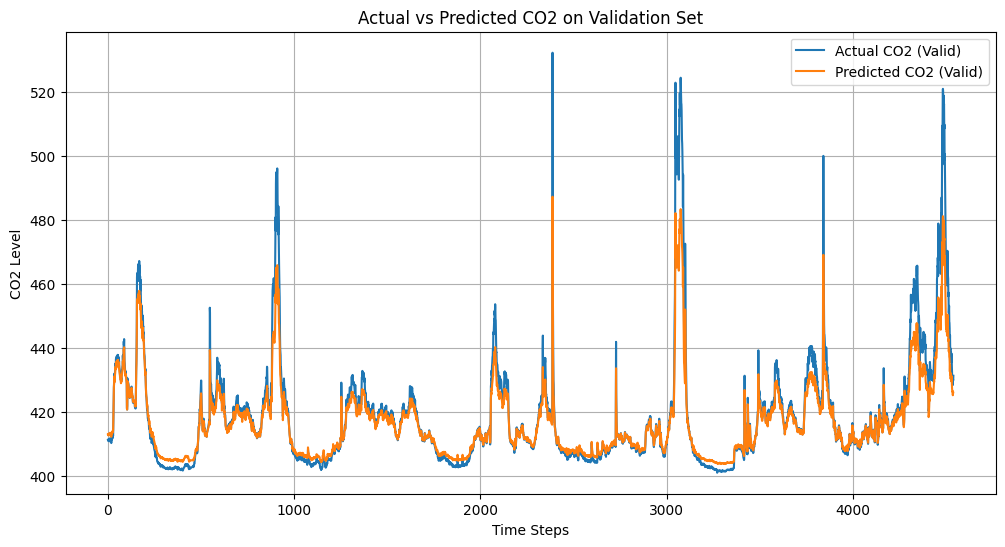

In [37]:
# Misal sudah inverse scaling
x_valid_inverse = scaler.inverse_transform(x_valid)
valid_pred_inverse = scaler.inverse_transform(valid_pred[:, 0, :])

plt.figure(figsize=(12,6))
plt.plot(x_valid_inverse[:, 0], label='Actual CO2 (Valid)')
plt.plot(valid_pred_inverse[:, 0], label='Predicted CO2 (Valid)')
plt.title('Actual vs Predicted CO2 on Validation Set')
plt.xlabel('Time Steps')
plt.ylabel('CO2 Level')
plt.legend()
plt.grid(True)
plt.show()



valid_pred shape: (4539, 1, 2)
x_valid shape: (4540, 2)


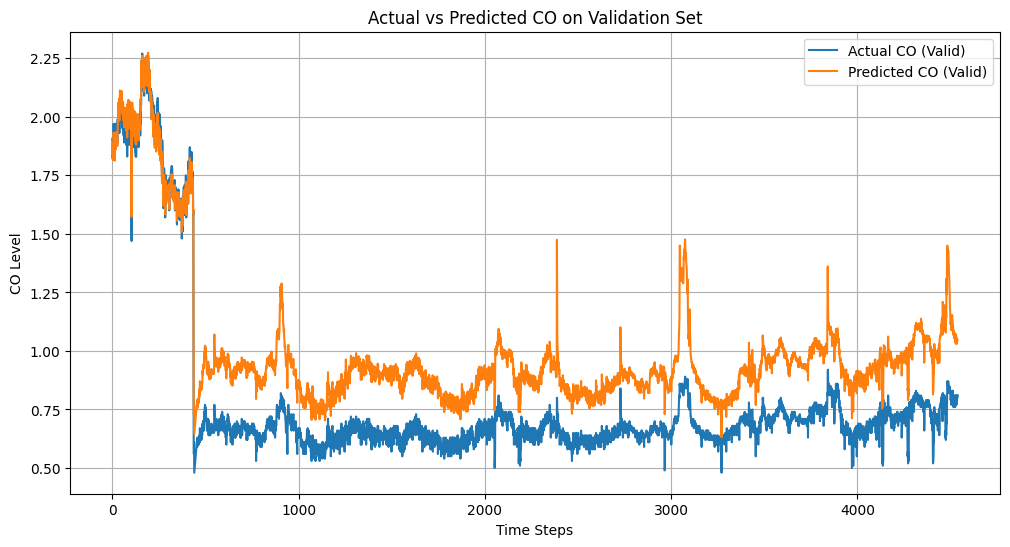

In [38]:
# Contoh cek shape
print('valid_pred shape:', valid_pred.shape)
print('x_valid shape:', x_valid.shape)

# Reshape valid_pred jika perlu
valid_pred_reshaped = valid_pred.reshape(valid_pred.shape[0], valid_pred.shape[2])

# Inverse scaling
x_valid_inverse = scaler.inverse_transform(x_valid)
valid_pred_inverse = scaler.inverse_transform(valid_pred_reshaped)

# Plot
plt.figure(figsize=(12,6))
plt.plot(x_valid_inverse[:, 1], label='Actual CO (Valid)')
plt.plot(valid_pred_inverse[:, 1], label='Predicted CO (Valid)')
plt.title('Actual vs Predicted CO on Validation Set')
plt.xlabel('Time Steps')
plt.ylabel('CO Level')
plt.legend()
plt.grid(True)
plt.show()



**Pemodelan Menggunakan LSTM**

In [39]:
df_per_2menit.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22696 entries, 2024-12-11 12:40:00+00:00 to 2025-01-12 01:10:00+00:00
Freq: 2min
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   entry_id  22696 non-null  float64
 1   CO2       22696 non-null  float64
 2   CO        22696 non-null  float64
dtypes: float64(3)
memory usage: 1.2 MB


In [40]:
df_per_2menit['2024-12-13':]

,entry_id,CO2,CO
created_at,,,
2024-12-13 00:00:00+00:00,6007.0,400.20,0.52
2024-12-13 00:02:00+00:00,6014.5,400.18,0.52
2024-12-13 00:04:00+00:00,6022.0,400.18,0.53
2024-12-13 00:06:00+00:00,6029.5,400.19,0.52
2024-12-13 00:08:00+00:00,6037.0,400.20,0.53
...,...,...,...
2025-01-12 01:02:00+00:00,160758.5,430.33,0.80
2025-01-12 01:04:00+00:00,160765.5,428.32,0.80
2025-01-12 01:06:00+00:00,160773.0,430.19,0.80


In [41]:
df_per_2menit.duplicated().sum()

0

Multivariat Multi Step Forecasting

In [42]:
# Tentukan proporsi
n = len(df_per_2menit)
train_size = int(n * 0.7)
val_size = int(n * 0.15)

# Split berdasarkan urutan waktu
train_df = df_per_2menit.iloc[:train_size]
val_df   = df_per_2menit.iloc[train_size:train_size + val_size]
test_df  = df_per_2menit.iloc[train_size + val_size:]


In [43]:
scaler = MinMaxScaler()
scaler.fit(train_df)

# 3. Transform semua data
train_scaled = scaler.transform(train_df)
valid_scaled = scaler.transform(val_df)
test_scaled  = scaler.transform(test_df)

Melakukan window splitting

In [44]:
tf.random.set_seed(42)

# Membuat fungsi untuk split data input dan target
def split_inputs_and_targets(mulvar_series, ahead=10, target_cols=[1, 2]):
    # input semua timestamp kecuali 10 langkah ke depan
    X = mulvar_series[:, :-ahead, :]

    # output: nilai aktual untuk 10 langkah kedepan
    Y = mulvar_series[:, -ahead:, :]
    Y = tf.gather(Y, target_cols, axis=-1)  # ambil hanya fitur target (CO2 dan CO)
    
    return X, Y

In [45]:
seq_length = 30

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    train_scaled,
    targets=None,
    sequence_length=seq_length + 10,
    batch_size=32,
    shuffle=True
).map(split_inputs_and_targets)

ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    valid_scaled,
    targets=None,
    sequence_length=seq_length + 10,
    batch_size=32,
    shuffle=True
).map(split_inputs_and_targets)


In [46]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

mulvar_multask_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=(None, 3)),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(10 * 2),
    tf.keras.layers.Reshape((10, 2))
])

In [47]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
mulvar_multask_model.compile(loss="mse", optimizer=optimizer, metrics=["MeanSquaredError"])

In [48]:
mulvar_multask_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 32)          4608      
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          8320      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 20)                660       
                                                                 
 reshape (Reshape)           (None, 10, 2)             0         
                                                                 
Total params: 21,908
Trainable params: 21,908
Non-trainable params: 0
_________________________________________________________________


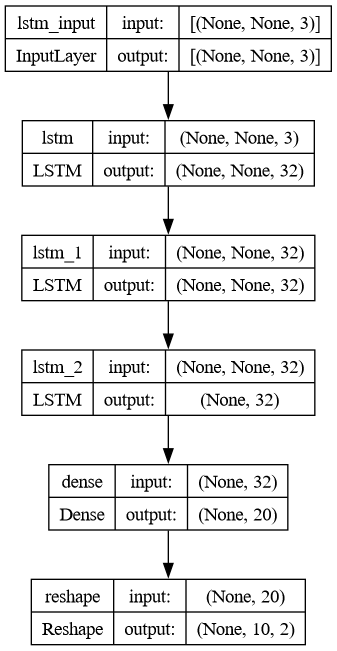

In [49]:
tf.keras.utils.plot_model(mulvar_multask_model, show_shapes=True)

In [50]:
with tf.device('/GPU:0'):
    history = mulvar_multask_model.fit(ahead_train_ds, epochs=30, validation_data=ahead_valid_ds)

Epoch 1/30
496/496 [==============================] - 10s 13ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 2/30
496/496 [==============================] - 5s 11ms/step - loss: 7.4954e-04 - mean_squared_error: 7.4954e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 3/30
496/496 [==============================] - 6s 11ms/step - loss: 6.6986e-04 - mean_squared_error: 6.6986e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/30
496/496 [==============================] - 5s 11ms/step - loss: 6.3088e-04 - mean_squared_error: 6.3088e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/30
496/496 [==============================] - 5s 11ms/step - loss: 6.1680e-04 - mean_squared_error: 6.1680e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/30
496/496 [==============================] - 6s 11ms/step - loss: 5.9672e-04 - mean_squared_error: 5.9672e-04 - val_loss: 0.0013 - val_mean_squ

In [51]:
valid_loss, valid_mae = mulvar_multask_model.evaluate(ahead_valid_ds)

106/106 [==============================] - 1s 5ms/step - loss: 0.0036 - mean_squared_error: 0.0036


In [53]:
ahead_test_ds = tf.keras.utils.timeseries_dataset_from_array(
    data=test_scaled,
    targets=None,
    sequence_length=seq_length + 10,  # contoh: 30 + 10 = 40
    batch_size=32,
    shuffle=False
).map(split_inputs_and_targets)


In [55]:
y_pred = mulvar_multask_model.predict(ahead_test_ds)  # hasil: shape (batch, 10, 2)

106/106 [==============================] - 1s 8ms/step


In [58]:
# Prediksi dari model
y_pred = mulvar_multask_model.predict(ahead_test_ds)

# Ambil ground truth dari dataset
y_true = []
for _, y in ahead_test_ds:
    y_true.append(y.numpy())

import numpy as np
y_true = np.concatenate(y_true, axis=0)  # shape: (samples, 10, 2)


106/106 [==============================] - 1s 7ms/step


In [59]:
# reshape ke 2D agar bisa di-inverse
y_pred_reshaped = y_pred.reshape(-1, 2)
y_true_reshaped = y_true.reshape(-1, 2)

# lakukan inverse transform
y_pred_original = scaler.inverse_transform(y_pred_reshaped).reshape(y_pred.shape)
y_true_original = scaler.inverse_transform(y_true_reshaped).reshape(y_true.shape)


ValueError: operands could not be broadcast together with shapes (33660,2) (3,) (33660,2) 